## Simulations for connecting random graphs through k-nearest-neighbors

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import networkx as nx 
import timeit
import math
from scipy.sparse import csr_matrix

In [3]:
def get_k_neighbors(X, k):
    # Inputs:
    # X - a cluster of points in the form of a 2D numpy array
    # k - number of neighbors desired
    #
    # Outputs:
    # indices - list of indices of nearest neighbors, with a list for each input point

    nbrs = NearestNeighbors(n_neighbors = k + 1, algorithm = "kd_tree").fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    return np.delete(indices, 0, axis = 1)

In [4]:
def get_k_partitioned_neighbors(X, k, num_partitions):
    # Inputs:
    # X - a cluster of points in the form of a 2D numpy array
    # k - number of neighbors desired
    # num_partitions - number of partitions into which X will be divided
    #
    # Outputs:
    # neighbors - list of indices of nearest neighbors, with a list for each input point
    
    partitions = np.array_split(X, num_partitions) # list of partitions
    
    # assign sink-partition not equal to source partition for each point in X.
    sinks = np.zeros(0)
    for source in range(num_partitions):
        possible_sinks = [i for i in range(num_partitions) if i != source]
        sinks = np.append(sinks, np.random.choice(a = possible_sinks, size = len(partitions[source])))
    
    neighbors = np.zeros((len(X), k))
    offset = 0
    for sink in range(num_partitions):
        # within the current sink partition, get all indices and points
        indices = (sinks == sink).nonzero()[0]
        points = X[indices]
        
        # fit kNN on current partition
        nbrs = NearestNeighbors(n_neighbors = k, algorithm = "kd_tree").fit(partitions[sink])
        # find neighbors (within partition) of the points to be compared
        partition_ind = nbrs.kneighbors(points)[1]
        
        #store indices of neighbors
        for i in range(len(indices)):
            neighbors[indices[i]] = partition_ind[i] + offset
        offset += len(partitions[sink])
        
    return neighbors

In [5]:
def create_graph(X, neighbors):
    # Inputs:
    # X - a cluster of points in the form of a 2D numpy array
    # k - a list of neighbors to be connected to each point in X, given by their indices
    #
    # Output:
    # G - the resulting graph
    #
    # Displays a graph with nodes at the points of X and connected neighbors
    
    pos = dict(enumerate(X))
    
    G = nx.Graph()
    G.add_nodes_from(range(len(X)))
    
    # for each node, add an edge for each neighbor 
    for n in pos.keys():
        G.add_edges_from([(n, i) for i in neighbors[n]])
    
    return G, pos

In [6]:
def draw_graph(G):
    plt.cla()
    nx.drawing.nx_pylab.draw_networkx(G[0], pos = G[1], 
                                      with_labels = False, node_size = 20, linewidths = 0.5)
    return G[0]

### Create graphs in 2-D using both methods

In [7]:
def k_nearest(X, k):
    # Simulate a random graph connection on the unit square, with points of X connecting to k neighbors
    
    # for each point, get k nearest neighbors
    neighbors = get_k_neighbors(X, k)
    
    # generate graph
    G = create_graph(X, neighbors)
    
    return G

In [8]:
def k_of_K_near(X, k, K):
    # Simulate a random graph connection on the unit square, with points of X connecting to a random k out of K neighbors
    
    assert k <= K, "k cannot be greater than K"
    
    # for each point, get K nearest neighbors
    K_neighbors = get_k_neighbors(X, K)
    # for each point, randomly choose k neighbors
    k_neighbors = np.apply_along_axis(lambda x: np.random.choice(x, k, replace = False), axis = 1, arr = K_neighbors)
    
    # generate graph
    G = create_graph(X, k_neighbors)
    
    return G
    

In [9]:
def k_of_K_part(X, k, K):
    # Simulate a random graph connection on the unit square, with points of X connecting to the nearest k neighbors in 
    # a random partion

    assert K % k == 0, "K must be a multiple of k"

    if K == k:
        return k_nearest(X, k)
    
    # shuffle points in X to randomize partitions
    shuffled = np.random.permutation(X)
    
    # array with list of indices for each nearest neighbor within a randomized partition
    partition_neighbors = get_k_partitioned_neighbors(shuffled, k, int(K/k))
    
    # generate graph
    G = create_graph(shuffled, partition_neighbors)
    
    return G

In [10]:
X = np.random.uniform(0, 1, 1000).reshape(500,2)

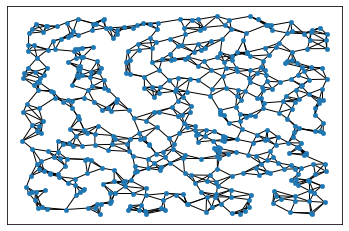

In [11]:
draw_graph(k_nearest(X, 4))

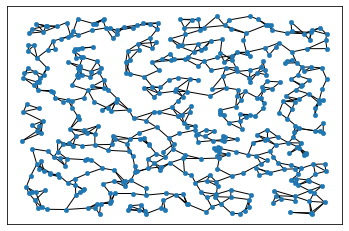

In [12]:
draw_graph(k_of_K_near(X, 2, 4))

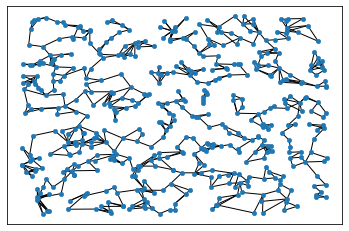

In [23]:
draw_graph(k_of_K_part(X, 2, 4))

In [21]:
n_points 
Y = np.random.uniform(0, 1, size = (n_points,2))

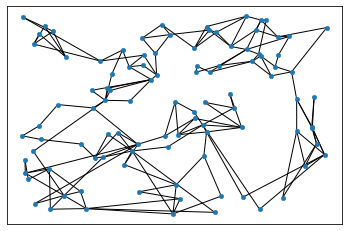

In [22]:
draw_graph(k_of_K_part(Y, 2, 6))

### Produce adjacency matrices for the resulting graphs

In [13]:
def adj_k_nearest(X, k):
    # Constructs an adjacency matrix (csr-format) for the graph formed by connecting n random 2-D points to their 
    # k neareast neighbors
    
    neighbors = get_k_neighbors(X, k)
    n_points = len(X)
    
    
    # create directed adjacency matrix using neighbors
    vals = np.ones(n_points * k)
    col_ind = neighbors.flatten()
    row_ptr = np.arange(n_points + 1) * k
    
    adj = csr_matrix((vals, col_ind, row_ptr))
    
    # reflect to create undirected adjacency
    return adj.maximum(adj.transpose())

In [14]:
def adj_k_of_K_near(X, k, K):
    # Constructs an adjacency matrix for the graph formed by connecting n random 2-D points to a random k-sized selection
    # of their K neareast neighbors
    
    assert k <= K, "k cannot be greater than K"
    
    n_points = len(X)
    
    K_neighbors = get_k_neighbors(X, K)
    # for each row, randomly choose k entries
    k_neighbors = np.apply_along_axis(lambda x: np.random.choice(x, k, replace = False), axis = 1, arr = K_neighbors)
    
    # create directed adjacency matrix using neighbors
    vals = np.ones(n_points * k)
    col_ind = k_neighbors.flatten()
    row_ptr = np.arange(n_points + 1) * k
    
    adj = csr_matrix((vals, col_ind, row_ptr))
    
    # reflect to create undirected adjacency
    return adj.maximum(adj.transpose())

In [15]:
def adj_k_of_K_part(X, k, K):
    # Constructs an adjacency matrix for the graph formed by connecting n random 2-D points to their k nearest neighbors
    # within a random partition
    
    assert K % k == 0, "K must be a multiple of k"

    if K == k:
        return adj_k_nearest(X, k)
    
    n_points = len(X)
    shuffled = np.random.permutation(X)
    partition_neighbors = get_k_partitioned_neighbors(shuffled, k, int(K/k))
    
    # create directed adjacency matrix using neighbors
    vals = np.ones(n_points * k)
    col_ind = partition_neighbors.flatten()
    row_ptr = np.arange(n_points + 1) * k
    
    adj = csr_matrix((vals, col_ind, row_ptr))
    
    # reflect to create undirected adjacency
    return adj.maximum(adj.transpose())

### Track efficiency of all three algorithms

In [17]:
start_time = timeit.default_timer()
X = np.random.uniform(0, 1, 1000000).reshape(500000,2)
adj_k_nearest(X, 3)
elapsed = timeit.default_timer() - start_time
elapsed

2.8272438

In [18]:
start_time = timeit.default_timer()
X = np.random.uniform(0, 1, 1000000).reshape(500000,2)
adj_k_of_K_near(X, 3, 6)
elapsed = timeit.default_timer() - start_time
elapsed

13.9818469

In [19]:
start_time = timeit.default_timer()
X = np.random.uniform(0, 1, 1000000).reshape(500000,2)
adj_k_of_K_part(X, 3, 6)
elapsed = timeit.default_timer() - start_time
elapsed

2.861210100000001

### Simulate to find component size

Connecting a graph of 10000 points in [0, 1]^d using nearest neighbors:

Monte Carlo Simulation parameters:
* dimension: [2, 4, 8]
* k: [3, 4, 5] (chosen because of critical points of 0.304 log(n) and 0.514 log(n) mentioned in paper)

For each, plot *number of components* and *size of largest component* as histograms.

In [95]:
def MC_sim1(dims, ks, num_points, num_sims):
    results = []
    for d in dims:
        for k in ks:
            data = np.empty((num_sims,2), dtype = int)
    
            for i in range(num_sims):
                X = np.random.uniform(0, 1, (num_points, d))
                G = k_nearest(X, k)[0]
                
                max_comp = len(max(nx.algorithms.components.connected_components(G), key=len))
                num_comps = nx.algorithms.components.number_connected_components(G)
                data[i] = [max_comp, num_comps]
                
            results.append(data)

    return results

In [96]:
dims = [2, 4, 8]
ks = [2, 3, 4, 5]
num_points = 1000
num_sims = 1000

results1 = MC_sim1(dims, ks, num_points, num_sims)

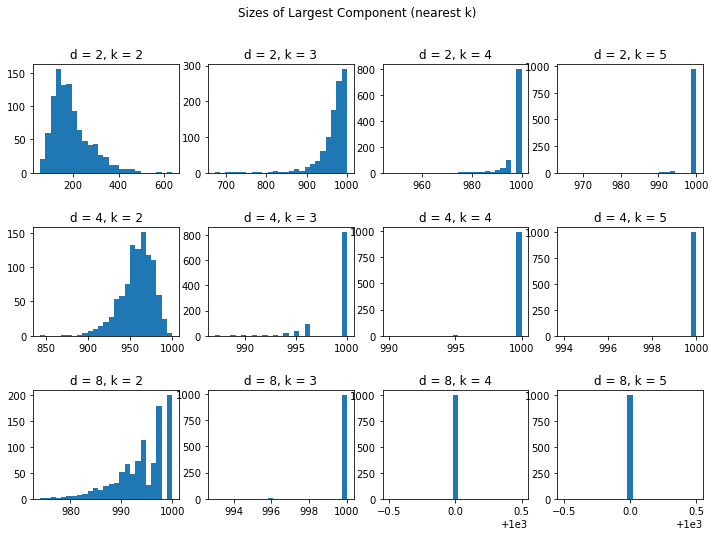

In [145]:
dims = [2, 4, 8]
ks = [2, 3, 4, 5]

fig, axes = plt.subplots(nrows=len(dims), ncols=len(ks), figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Sizes of Largest Component (nearest k)')

names = ['d = {0}, k = {1}'.format(d, k) for d in dims for k in ks]

for ax, data, name in zip(axes.flatten(), results1, names):
    ax.hist(data[:,0], bins = 25)
    ax.set(title=name)

Connecting a graph of 10000 points in [0, 1]^d using k of K near neighbors (complete algorithm):

Monte Carlo Simulation parameters:
* dimension: [2, 4]
* k: [2, 3, 4] (chosen to represent K as log(n) and k as log(log(n))
* K: [10, 18, 52] 

For each, plot *number of components* and *size of largest component* as histograms.

In [74]:
def MC_sim2(dims, k_mat, num_points, num_sims):
    results = []
    for d in dims:
        for (k, K) in k_mat:
            data = np.empty((num_sims,2), dtype = int)
    
            for i in range(num_sims):
                X = np.random.uniform(0, 1, (num_points, d))
                G = k_of_K_near(X, k, K)[0]
                max_comp = len(max(nx.algorithms.components.connected_components(G), key=len))
                num_comps = nx.algorithms.components.number_connected_components(G)
                data[i] = [max_comp, num_comps]
                
            results.append(data)

    return results

In [107]:
dims = [2, 4]
ks = np.array([[2, 4], [3, 4], [3, 5]])
num_points = 5000
num_sims = 1000

results2 = MC_sim2(dims, ks, num_points, num_sims)

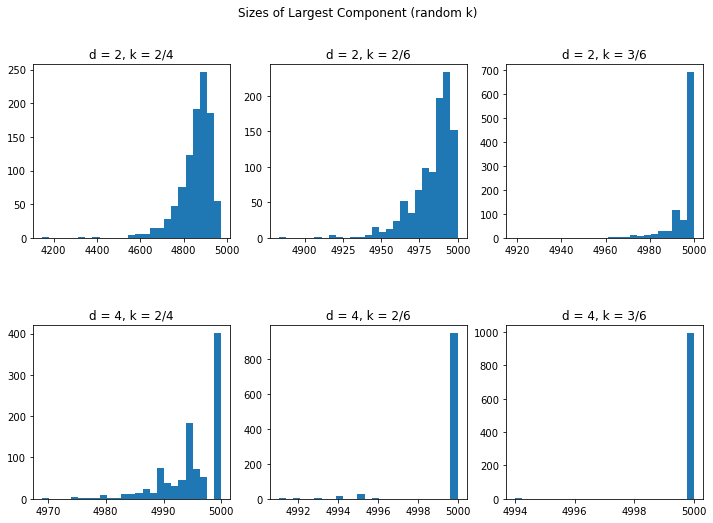

In [144]:
fig, axes = plt.subplots(nrows=len(dims), ncols=len(ks), figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Sizes of Largest Component (random k)')

names = ['d = {0}, k = {1}/{2}'.format(d, k[0], k[1]) for d in dims for k in ks]

for ax, data, name in zip(axes.flatten(), results2, names):
    ax.hist(data[:,0], bins = 25)
    ax.set(title=name)

Connecting a graph of 10000 points in [0, 1]^d using k of K near neighbors (partitioned algorithm):

Monte Carlo Simulation parameters:
* dimension: [2, 4]
* k: [2, 3, 4] (chosen to represent K as log(n) and k as log(log(n))
* K: [10, 18, 52] 

For each, plot *number of components* and *size of largest component* as histograms.

In [87]:
def MC_sim3(dims, k_mat, num_points, num_sims):
    results = []
    for d in dims:
        for (k, K) in k_mat:
            data = np.empty((num_sims,2), dtype = int)
    
            for i in range(num_sims):
                X = np.random.uniform(0, 1, (num_points, d))
                G = k_of_K_part(X, k, K)[0]
                max_comp = len(max(nx.algorithms.components.connected_components(G), key=len))
                num_comps = nx.algorithms.components.number_connected_components(G)
                data[i] = [max_comp, num_comps]
                
            results.append(data)

    return results

In [110]:
dims = [2, 4]
ks = np.array([[2, 4], [2, 6], [3, 6]])
num_points = 5000
num_sims = 1000

results3 = MC_sim3(dims, ks, num_points, num_sims)

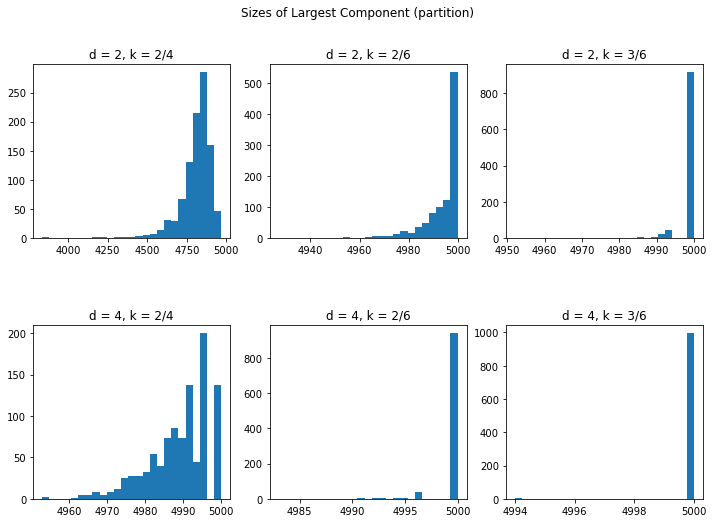

In [143]:
fig, axes = plt.subplots(nrows=len(dims), ncols=len(ks), figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Sizes of Largest Component (partition)')

names = ['d = {0}, k = {1}/{2}'.format(d, k[0], k[1]) for d in dims for k in ks]

for ax, data, name in zip(axes.flatten(), results3, names):
    ax.hist(data[:,0], bins = 25)
    ax.set(title=name)

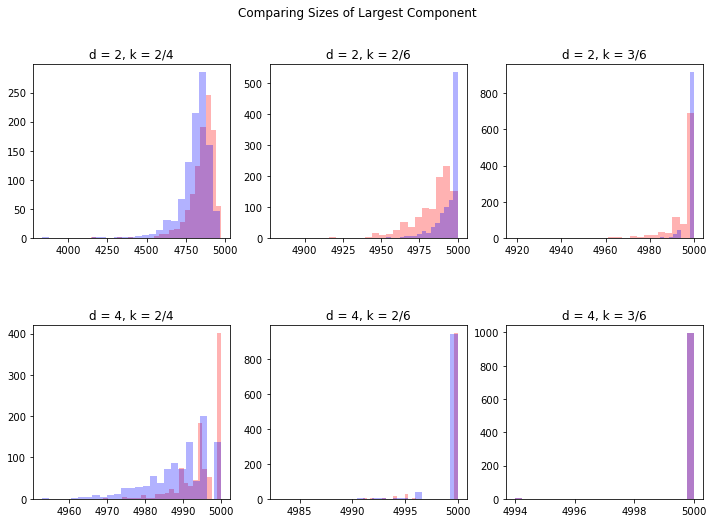

In [114]:
fig, axes = plt.subplots(nrows=len(dims), ncols=len(ks), figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Comparing Sizes of Largest Component')

names = ['d = {0}, k = {1}/{2}'.format(d, k[0], k[1]) for d in dims for k in ks]

for ax, data2, data3, name in zip(axes.flatten(), results2, results3, names):
    ax.hist(data2[:,0], bins = 25, fc=(1, 0, 0, 0.3))
    ax.hist(data3[:,0], bins = 25, fc=(0, 0, 1, 0.3))
    ax.set(title=name)

How many of the generated graphs were connected?

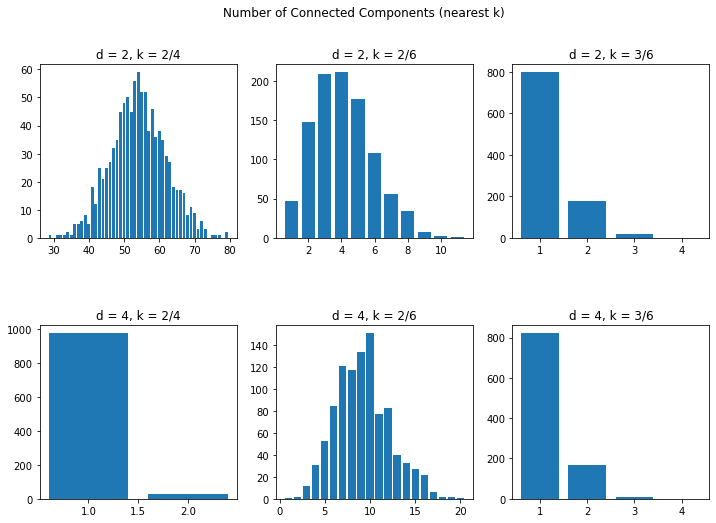

In [142]:
fig, axes = plt.subplots(nrows=len(dims), ncols=len(ks), figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Number of Connected Components (nearest k)')

names = ['d = {0}, k = {1}/{2}'.format(d, k[0], k[1]) for d in dims for k in ks]

for ax, data, name in zip(axes.flatten(), results1, names):
    nunique = np.unique(data[:,1], return_counts = True)
    ax.bar(nunique[0],nunique[1])
    ax.set(title=name)

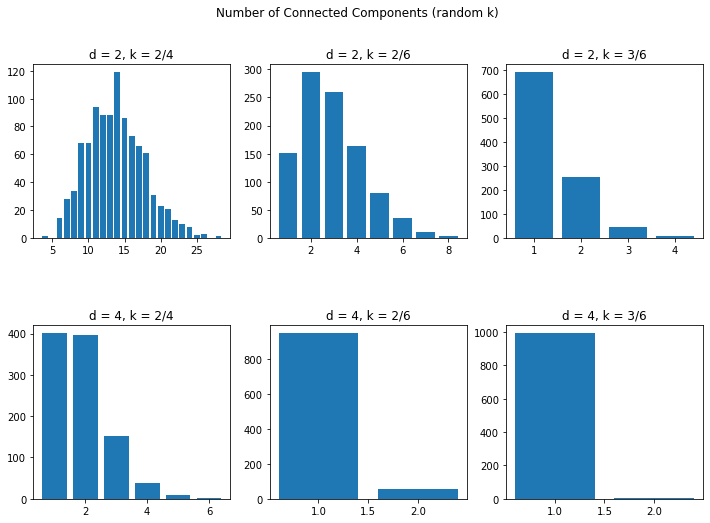

In [141]:
fig, axes = plt.subplots(nrows=len(dims), ncols=len(ks), figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Number of Connected Components (random k)')

names = ['d = {0}, k = {1}/{2}'.format(d, k[0], k[1]) for d in dims for k in ks]

for ax, data, name in zip(axes.flatten(), results2, names):
    nunique = np.unique(data[:,1], return_counts = True)
    ax.bar(nunique[0],nunique[1])
    ax.set(title=name)

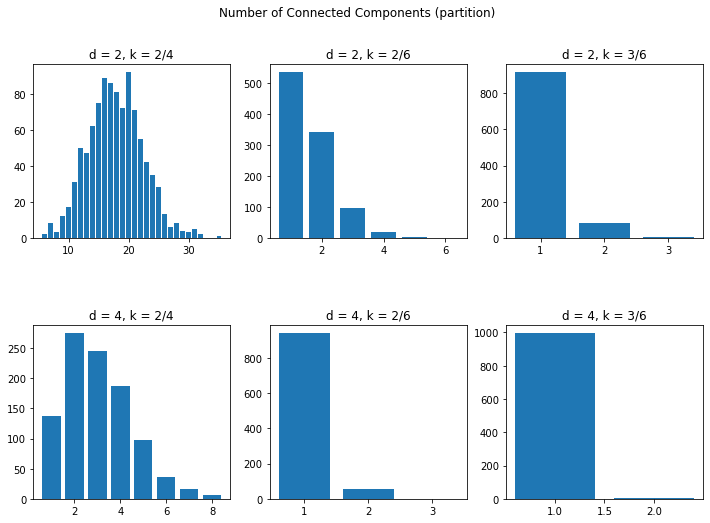

In [140]:
fig, axes = plt.subplots(nrows=len(dims), ncols=len(ks), figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Number of Connected Components (partition)')

names = ['d = {0}, k = {1}/{2}'.format(d, k[0], k[1]) for d in dims for k in ks]

for ax, data, name in zip(axes.flatten(), results3, names):
    nunique = np.unique(data[:,1], return_counts = True)
    ax.bar(nunique[0],nunique[1])
    ax.set(title=name)